In [22]:
# --- Run Imports ---

import os
import time

import numpy as np
import pandas as pd
import csv
import scipy.signal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import optuna
from imblearn.over_sampling import SMOTE
import wandb
import pywt

import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFloat
from brevitas.quant import Uint8ActPerTensorFloat, Int8ActPerTensorFloat
import brevitas.onnx as bo
from brevitas.inject.defaults import RoundTo8bit



# Use GPU if Available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [23]:
# --- Data preprocessing & loading with SMOTE ---

AMII_CLASSES = ['N', 'S', 'V', 'F', 'Q']
num_classes = len(AMII_CLASSES)

#Apply Discrete Wavelet Transform (DWT) for denoising ECG signals.
def apply_dwt_denoising(ecg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)  # Decompose signal
    coeffs[1:] = [pywt.threshold(c, np.std(c) * 0.5, mode="soft") for c in coeffs[1:]]  # Threshold details
    return pywt.waverec(coeffs, wavelet)[:len(ecg_signal)]  # Reconstruct & trim

def load_data(csv_file):
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"File not found: {csv_file}")
        return None, None, None

    # --- Normalize ECG Signal ---
    ecg_sig = (df['MLII'].values.astype(np.float32) - np.mean(df['MLII'])) / np.std(df['MLII'])

    # --- Apply DWT for Denoising ---
    ecg_sig = apply_dwt_denoising(ecg_sig)  # 🔹 DWT applied here

    # Extract labeled events (R-peaks)
    label_series = df[df['Type'] != '-'][['Sample', 'Type']]
    r_peaks = label_series['Sample'].values.astype(int)

    return ecg_sig, label_series, r_peaks


# ECG Dataset with optional SMOTE balancing.
class ECGDataset(Dataset):
    def __init__(self, data_dir, beat_length=256, stride=1):
        super(ECGDataset, self).__init__()
        self.data_dir = data_dir
        self.beat_length = beat_length
        self.stride = stride
        self.data_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
        self.labeled_events = []  # Store ECG segments with filenames

        self.label_map = {label: index for index, label in enumerate(AMII_CLASSES)}
        print(self.label_map)
        self.class_counts = {label: 0 for label in AMII_CLASSES}  # Debugging class count

        for csv_file in self.data_files:
            ecg_sig, label_series, r_peaks = load_data(os.path.join(data_dir, csv_file))
            if ecg_sig is not None and len(r_peaks) > 0:
                for index, row in label_series.iterrows():
                    sample_number = int(row['Sample'])
                    label = self.label_map.get(row['Type'], -1)

                    if label != -1:
                        ecg_window = self.get_fixed_beat(ecg_sig, r_peaks, sample_number)

                        if ecg_window is not None:
                            self.labeled_events.append((csv_file, ecg_window, label))
                            self.class_counts[AMII_CLASSES[label]] += 1

        print(f"Initial class distribution: {self.class_counts}")

        # Convert dataset to PyTorch tensors
        self.labeled_events = [(f, torch.tensor(sig).float(), torch.tensor(lbl).long()) for f, sig, lbl in self.labeled_events]

    # Resample input to 256 samples
    def resample_ecg(self, ecg_segment, target_length=256):
        if len(ecg_segment) == target_length:
            return ecg_segment
        return scipy.signal.resample(ecg_segment, target_length)

    def get_fixed_beat(self, ecg_sig, r_peaks, sample_number):
        peak_idx = np.where(r_peaks == sample_number)[0]

        if len(peak_idx) == 0 or peak_idx[0] == 0 or peak_idx[0] >= len(r_peaks) - 1:
            return None  # Skip if at the boundary

        peak_idx = peak_idx[0]
        start_idx = r_peaks[peak_idx - 1]
        end_idx = r_peaks[peak_idx + 1]

        ecg_beat = ecg_sig[start_idx:end_idx]
        return self.resample_ecg(ecg_beat, self.beat_length)

    # Uses SMOTE to generate synthetic samples for the minority classes. 
    # ONLY TO BE DONE ON TRAINING DATASET!!!!!! 
    
    # def apply_smote_balancing(self):
    #     print("Applying SMOTE for class balancing...")

    #     # Extract features (beats) and labels
    #     X = np.array([sig for _, sig, _ in self.labeled_events])
    #     y = np.array([lbl for _, _, lbl in self.labeled_events])

    #     # Flatten ECG beats to 1D (necessary for SMOTE)
    #     X_flattened = X.reshape(X.shape[0], -1)  # Shape: (num_samples, beat_length)

    #     # Apply SMOTE
    #     smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    #     X_resampled, y_resampled = smote.fit_resample(X_flattened, y)

    #     # Reshape back to original form
    #     X_resampled = X_resampled.reshape(X_resampled.shape[0], self.beat_length)

    #     # Update labeled events
    #     self.labeled_events = [(None, x, int(y)) for x, y in zip(X_resampled, y_resampled)]

    #     # Update class counts
    #     new_class_counts = {label: np.sum(y_resampled == idx) for label, idx in self.label_map.items()}
    #     print(f"New class distribution after SMOTE: {new_class_counts}")

    def __len__(self):
        return len(self.labeled_events)

    def __getitem__(self, idx):
        _, ecg_beat, label = self.labeled_events[idx]
        #ecg_beat = ecg_beat.unsqueeze(0).unsqueeze(1)  # Add channel dimension for CNN
        ecg_beat = ecg_beat.view(1, 256, 1)
        return ecg_beat, label


In [24]:
# --- Load Dataset Into Env ---
csv_file_dir = '/home/eveneiha/finn/workspace/ml/data/mitDB_AMII'
full_dataset = ECGDataset(csv_file_dir)

{'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
Initial class distribution: {'N': 89012, 'S': 2772, 'V': 7176, 'F': 802, 'Q': 6781}


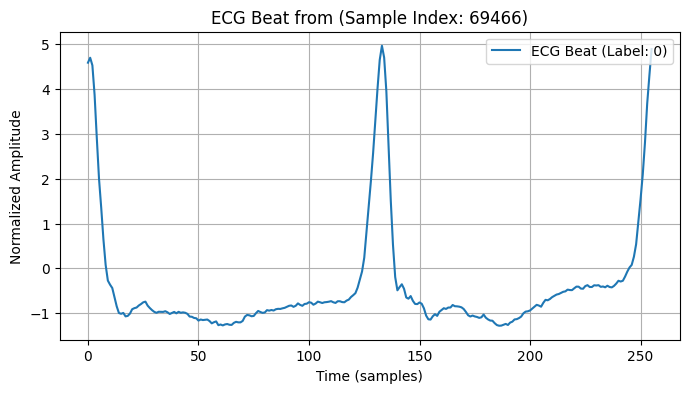

In [15]:
# plot to viz
# Select a random index from the dataset
sample_idx = np.random.randint(0, len(full_dataset))

# Fetch the sample
ecg_sample, label = full_dataset[sample_idx]

# Convert to numpy for plotting
ecg_sample_np = ecg_sample.squeeze().numpy()  # Remove channel dimension

# Plot the ECG beat
plt.figure(figsize=(8, 4))
plt.plot(ecg_sample_np, label=f"ECG Beat (Label: {label.item()})")
plt.title(f"ECG Beat from (Sample Index: {sample_idx})")
plt.xlabel("Time (samples)")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
class QuantizedTemporalBlock2d(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, dropout=0.2):
        super(QuantizedTemporalBlock2d, self).__init__()
        # Compute fixed, symmetric padding for the temporal dimension.
        fixed_padding = ((kernel_size - 1) * dilation) // 2

        # Input quantization identity
        #self.quant_inp = qnn.QuantIdentity(bit_width=8, act_quant=Int8ActPerTensorFloat)

        # Two quantized convolutional layers
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs, kernel_size=(kernel_size, 1),
            stride=(stride, 1), padding=(fixed_padding, 0),
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerTensorFloat,  # Quantizes weights to INT8
            input_quant=Int8ActPerTensorFloat,          # Quantizes activations to INT8
            weight_bit_width=8,
            act_bit_width=8,
            bias=False)
        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs, kernel_size=(kernel_size, 1),
            stride=(stride, 1), padding=(fixed_padding, 0),
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerTensorFloat,  # Quantizes weights to INT8
            input_quant=Int8ActPerTensorFloat,          # Quantizes activations to INT8
            weight_bit_width=8,
            act_bit_width=8,
            bias=False)

        self.dropout = nn.Dropout(dropout)

        # QuantReLU after the conv branch (with quant tensor output)
        self.relu_after_conv = qnn.QuantReLU(return_quant_tensor=True)

        # **Uniform quantizers added on both branches:**
        #self.quant_main = qnn.QuantIdentity(bit_width=8, return_quant_tensor=True)
        #self.quant_res = qnn.QuantIdentity(bit_width=8, return_quant_tensor=True)

        # QuantReLU after the residual addition
        self.relu_after_residual = qnn.QuantReLU(return_quant_tensor=True)

        # Downsample (1×1 conv) for the skip connection if channel dimensions differ.
        if n_inputs != n_outputs:
            self.downsample = qnn.QuantConv2d(
                n_inputs, n_outputs, kernel_size=(1, 1),
                weight_quant=Int8WeightPerTensorFloat, 
                input_quant= Int8ActPerTensorFloat)
        else:
            self.downsample = None

    def forward(self, x):
        # Main branch:
        out = self.conv1(x)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.relu_after_conv(out).value  # unwrap quantized tensor after ReLU
        out = self.dropout(out)
        #out = self.quant_main(out).value         # apply uniform quantizer on main branch

        # Residual branch:
        #res = x if self.downsample is None else self.downsample(x)
        #res = self.quant_res(res).value          # apply uniform quantizer on residual branch

        # Add branches and apply final quantized activation.
        #out = out + res
        out = self.relu_after_residual(out).value

        return out





class QuantizedTCN2d(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels, kernel_size, dropout, dilation_factor):
        super(QuantizedTCN2d, self).__init__()
        self.num_channels = num_channels
        self.temporal_blocks = nn.ModuleList()

        for i in range(len(num_channels)):
            dilation_size = dilation_factor ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            # For conv2d, padding becomes (0, (kernel_size-1)*dilation)
            # padding = (kernel_size - 1) * dilation_size
            self.temporal_blocks.append(
                QuantizedTemporalBlock2d(in_channels, out_channels, kernel_size, stride=1,
                                           dilation=dilation_size, dropout=dropout))
        # NOT FINN COPAT: self.fc = qnn.QuantLinear(num_channels[-1], num_outputs, weight_quant=Int8WeightPerTensorFloat, input_quant=Int8ActPerTensorFloat, bias=False)
        
        self.fc = qnn.QuantConv2d(
            in_channels=num_channels[-1],
            out_channels=num_outputs,
            kernel_size=(1, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            bias=False
        )
        
        self.inp_quant = qnn.QuantIdentity(bit_width=8, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True)
        self.inp_quant2 = qnn.QuantIdentity(bit_width=8, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True)

       
    def forward(self, x):
      x = self.inp_quant(x)
      for block in self.temporal_blocks:
          x = block(x)

      if hasattr(x, "value"):
          x = x.value

      # Average pooling to (1,1), then explicitly reshape (FINN compatible)
      # x shape: (N, C, L)
      #x = F.adaptive_avg_pool2d(x, (1,1))    # -> (N, C, 1)

      
      x = F.adaptive_avg_pool2d(x, (1, 1))
      # TODO: check quant optimizatiosn : x = self.inp_quant2(x)

      
         # -> (N, C)
     
    
      
      x = self.fc(x)
      x = x.reshape(x.size(0), -1)
    
      # Average pooling to (1,1), then explicitly reshape (FINN compatible)
      # x shape: (N, C, L)
    #   x = F.adaptive_avg_pool2d(x, (1,1))    # -> (N, C, 1)
    #   x = x.reshape(x.size(0), -1)  
      return x




In [17]:
# --- Model Config ---
## Create model

# --- Model Config ---
input_channels = 1      # 1 ECG channel
num_channels = [4, 8, 16]  # Number of channels at each block
output_channels = 5     # e.g., number of classes
kernel_size = 5
dilation_factor = 4
dropout = 0.074
lr = 0.008
batch_size = 256

# Instantiate the modified model
tcn = QuantizedTCN2d(input_channels, output_channels, num_channels, kernel_size, dropout, dilation_factor)

dummy_input = torch.randn(1, 1, 256, 1)  # Adjust dimensions if needed
tcn(dummy_input)

optimizer = optim.Adam(tcn.parameters(), lr=lr)

# Print model summary
summary(tcn, input_size=(1, 1, 256, 1))  # (batch_size, channels, sequence_length)


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                                                      Output Shape              Param #
QuantizedTCN2d                                                              [1, 5]                    --
├─QuantIdentity: 1-1                                                        [1, 1, 256, 1]            --
│    └─ActQuantProxyFromInjector: 2-1                                       [1, 1, 256, 1]            --
│    └─ActQuantProxyFromInjector: 2-2                                       [1, 1, 256, 1]            --
│    │    └─FusedActivationQuantProxy: 3-1                                  [1, 1, 256, 1]            1
├─QuantIdentity: 1-30                                                       --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-33                                      --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-47                                 --                        (recursive)
├─QuantIdentity: 1-3    

In [ ]:
# Split training, validation and testing

train_size = 0.7
val_size = 0.15
test_size = 0.15
loss_function = "label_smoothing"
# Stratified Data Split (with reduced size)
labels = [label.item() for _, label  in full_dataset]

# First, split train + temp (validation+test)
train_idx, temp_idx = train_test_split(
    list(range(len(full_dataset))), test_size=1 - train_size, stratify=labels, random_state=42)
# Get labels for second split (validation/test)
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=test_size/(test_size + val_size), stratify=temp_labels, random_state=42)


# --- Save splits to disk ---
def extract_data(subset):
    all_inputs = []
    all_labels = []
    for inp, lbl in subset:
        all_inputs.append(inp)
        all_labels.append(lbl)
    return torch.stack(all_inputs), torch.tensor(all_labels)

def apply_smote_to_subset(subset, beat_length=256):
    print("Applying SMOTE for class balancing...")

    X = []
    y = []
    for ecg, label in subset:
        X.append(ecg.view(-1).numpy())  # flatten
        y.append(label.item())
    X = np.array(X)
    y = np.array(y)

    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_res, y_res = smote.fit_resample(X, y)

    # Reshape back to original ECG beat shape
    X_res = X_res.reshape(-1, 1, beat_length, 1)
    tensor_inputs = torch.tensor(X_res).float()
    tensor_labels = torch.tensor(y_res).long()

    # Calculate class distribution
    unique, counts = np.unique(y_res, return_counts=True)
    new_class_counts = {label: count for label, count in zip(unique, counts)}
    print(f"New class distribution after SMOTE: {new_class_counts}")

    return list(zip(tensor_inputs, tensor_labels))

save_dir = "/home/eveneiha/finn/workspace/ml/data/preprocessed/"
os.makedirs(save_dir, exist_ok=True)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

train_dataset = apply_smote_to_subset(train_dataset)

train_inputs, train_labels = extract_data(train_dataset)
val_inputs, val_labels = extract_data(val_dataset)
test_inputs, test_labels = extract_data(test_dataset)
torch.save((train_inputs, train_labels), os.path.join(save_dir, "train.pt"))
torch.save((val_inputs, val_labels), os.path.join(save_dir, "val.pt"))
torch.save((test_inputs, test_labels), os.path.join(save_dir, "test.pt"))


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

test_labels = [label.item() for _, label in test_dataset]
print("Unique labels in test set:", set(test_labels))


# Calculate class weights
labels = []
for _,label in full_dataset:
  labels.append(label)
class_counts = torch.bincount(torch.stack(labels))
class_weights = 1.0 / (class_counts + 1e-7)
print("Class Weights: ", class_weights)


# --- Define Loss and Optimizer ---
# --- Select Loss Function ---
if loss_function == "cross_entropy":
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
elif loss_function == "label_smoothing":
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)

Applying SMOTE for class balancing...
New class distribution after SMOTE: {0: 62308, 1: 62308, 2: 62308, 3: 62308, 4: 62308}
Unique labels in test set: {0, 1, 2, 3, 4}
Class Weights:  tensor([1.1234e-05, 3.6075e-04, 1.3935e-04, 1.2469e-03, 1.4747e-04])


In [21]:
# ---------------------- Training Parameters ----------------------
num_epochs = 5  # number of training loops over the training dataset

# Lists for plotting Loss
training_losses = []
validation_losses = []


# --- Logging with wandB ---
wandb.init(project="tcn_experiments")

wandb.config.num_channels = num_channels
wandb.config.kernel_size = kernel_size
wandb.config.dropout = dropout
wandb.config.batch_size = batch_size
wandb.config.learning_rate = lr


# ---------------------- Training Loop ----------------------
tcn.train()
tcn.to(device) # Transfer model to GPU

running_loss = 0
running_correct = 0

for epoch in range(num_epochs):
    total_loss = 0
    batch_num = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        #Transfer data to GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        #Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = tcn(inputs) # apply the TCN to the input
        # Calculate the loss
        loss = criterion(outputs, targets)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()

        running_loss += loss.item() # update running loss
        _, predicted = torch.max(outputs, 1) # get the class prediction
        running_correct += (predicted == targets).sum().item() # update running correct

        # Log the progress
        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}")
            # writer.add_scalar("Training loss", running_loss / 100 , epoch * len(train_dataloader) + batch_idx)
            # writer.add_scalar("Accuracy", running_correct / 100 , epoch * len(train_dataloader) + batch_idx)
            running_loss = 0.0
            running_correct = 0

        total_loss += loss.item() # update total loss
        batch_num+=1

    training_loss_avg = total_loss / batch_num
    training_losses.append(training_loss_avg) # append training loss to the list
   # writer.add_scalar("Loss/Train", training_loss_avg, epoch)

    train_loss = total_loss / len(train_dataloader)

    # --- Validation ---
    tcn.eval()  # ✅ Switch to evaluation mode
    total_loss_val = 0
    batch_num_val = 0
    correct, total = 0, 0  # ✅ Initialize accuracy tracking

    with torch.no_grad():
        for batch_idx_val, (inputs_val, targets_val) in enumerate(val_dataloader):
            inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)

            # Forward pass
            outputs_val = tcn(inputs_val)

            # Calculate loss
            loss_val = criterion(outputs_val, targets_val)
            total_loss_val += loss_val.item()
            batch_num_val += 1


            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_loss_avg = total_loss_val / batch_num_val
    validation_losses.append(val_loss_avg)
    val_acc = correct / total

    # 🔹 Print validation results
    print(f"📊 Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss_avg:.4f}, Val Acc={val_acc:.4f}")

    tcn.train()




wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eveneha (elsysai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1/5, Batch: 0/1217, Loss: 1.5952
Epoch: 1/5, Batch: 100/1217, Loss: 0.9192


KeyboardInterrupt: 

Test Loss: 0.5379, Test Accuracy: 0.9565


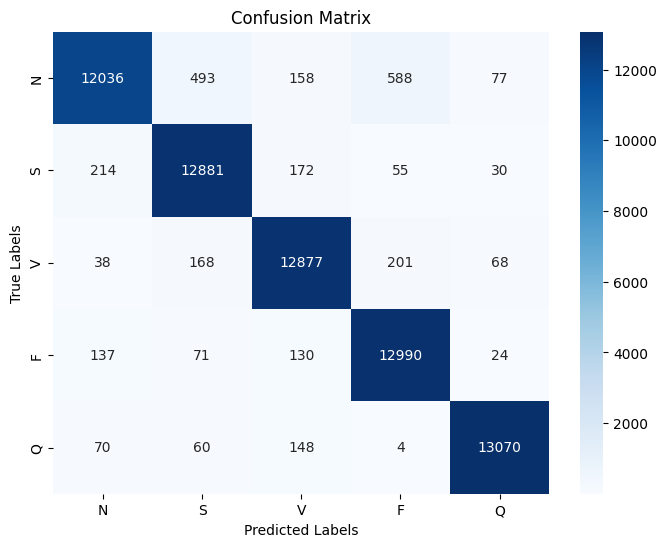

Unique values in all_targets: [0 1 2 3 4]
Unique values in all_preds: [0 1 2 3 4]
Classification Report:
               precision    recall  f1-score   support

           N       0.96      0.90      0.93     13352
           S       0.94      0.96      0.95     13352
           V       0.95      0.96      0.96     13352
           F       0.94      0.97      0.96     13352
           Q       0.99      0.98      0.98     13352

    accuracy                           0.96     66760
   macro avg       0.96      0.96      0.96     66760
weighted avg       0.96      0.96      0.96     66760



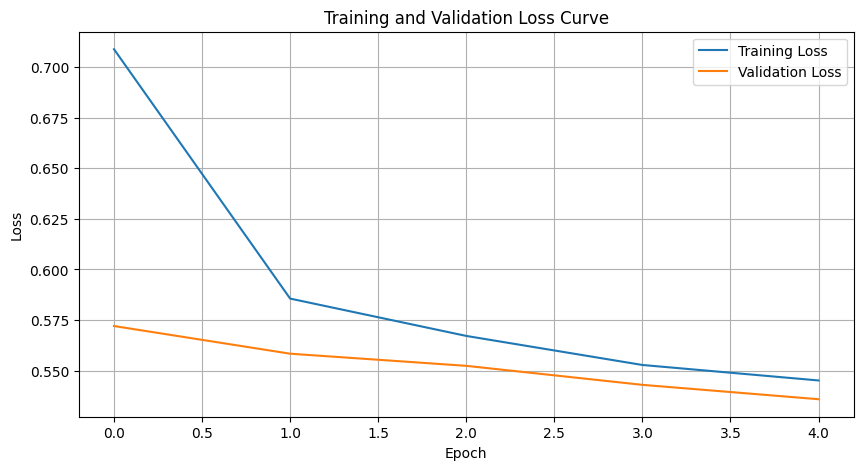

📊 **Total Macro F1-Score**: 0.9563
📊 **Total Weighted F1-Score**: 0.9563


In [ ]:
# --- Evaluation ---

tcn.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_loss = 0
correct, total = 0, 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = tcn(inputs)

        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1) # get the class prediction
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        all_preds.extend(predicted.cpu().numpy()) # store predictions
        all_targets.extend(targets.cpu().numpy()) # store target labels

test_loss /= len(test_dataloader)
test_accuracy = correct / total

# wandb.run.summary["Final test_loss"] = test_loss
# wandb.run.summary["Finnal test_accuracy"] = test_accuracy
# wandb.finish()
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=AMII_CLASSES, yticklabels=AMII_CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Unique values in all_targets:", np.unique(all_targets))
print("Unique values in all_preds:", np.unique(all_preds))


# Generate classification report
print("Classification Report:\n", classification_report(all_targets, all_preds, target_names=AMII_CLASSES, zero_division=0))

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), training_losses, label='Training Loss')
plt.plot(range(num_epochs), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# --- Compute Total F1-Scores ---
macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 **Total Macro F1-Score**: {macro_f1:.4f}")
print(f"📊 **Total Weighted F1-Score**: {weighted_f1:.4f}")




In [38]:
# --- Save model ---
torch.save({
    'model_state_dict': tcn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # If you want to save optimizer state
}, '/home/eveneiha/finn/workspace/ml/intermidiate_models/tcn_model_v32.pth')

print("Training Done, model weights are saved")



Training Done, model weights are saved


In [ ]:
# --- Restore old Models
# CPU:
checkpoint = torch.load('/home/eveneiha/finn/workspace/ml/intermidiate_models/tcn_model_v32.pth', map_location=torch.device('cpu'))


# GPU
# checkpoint = torch.load('/content/drive/MyDrive/Master/tcn_model_v32.pth')
tcn.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # If needed
tcn.eval()


/tmp/ipykernel_126446/1219979239.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/eveneiha/finn/workspace/ml/intermidiate_models/tcn_model_

QuantizedTCN2d(
  (temporal_blocks): ModuleList(
    (0): QuantizedTemporalBlock2d(
      (conv1): QuantConv1d(
        1, 4, kernel_size=(5,), stride=(1,), padding=(2,), bias=False
        (input_quant): ActQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
          (fused_activation_quant_proxy): FusedActivationQuantProxy(
            (activation_impl): Identity()
            (tensor_quant): RescalingIntQuant(
              (int_quant): IntQuant(
                (float_to_int_impl): RoundSte()
                (tensor_clamp_impl): TensorClamp()
                (delay_wrapper): DelayWrapper(
                  (delay_impl): _NoDelay()
                )
                (input_view_impl): Identity()
              )
              (scaling_impl): ParameterFromRuntimeStatsScaling(
                (stats_input_view_shape_impl): OverTensorView()
                (stats): _Stats(
                  (stats_impl): AbsPercentile()
                )
                (restrict_sc

In [34]:
from brevitas.export import export_qonnx

# scale_factor = 9.607829269953072e7  # example value from your Mul node

# with torch.no_grad():
#     # multiply final FC weights
#     tcn.fc.weight *= scale_factor
#     # if you had a bias and needed to fold it too:
#     # model.fc.bias *= scale_factor

tcn.eval()
tcn = tcn.to(device)
# Create quantizer
dummy_input = torch.randn(1, 1, 256, 1).to(device)

export_qonnx(tcn, dummy_input, export_path='/home/eveneiha/finn/workspace/finn/onnx/tcn_v33.onnx', opset_version=9)




ir_version: 4
producer_name: "pytorch"
producer_version: "2.4.1"
graph {
  node {
    input: "x.721"
    input: "/inp_quant/act_quant/export_handler/Constant_1_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_2_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_output_0"
    output: "/inp_quant/act_quant/export_handler/Quant_output_0"
    name: "/inp_quant/act_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 0
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attribute {
      name: "signed"
      i: 1
      type: INT
    }
    domain: "onnx.brevitas"
  }
  node {
    input: "/inp_quant/act_quant/export_handler/Quant_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_2_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_output_0"
    